# Using semantic_models module for semantic segmentation

**NOTE:** Use the `sm-legacy` environment.

## Check GPU Support

In [1]:
import tensorflow as tf
print("TF Version:", tf.__version__)
gpus = tf.config.list_physical_devices("GPU")
print("GPUs detected:", gpus)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())

TF Version: 2.2.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
Built with GPU support: True


## Loading the dataset

In [2]:
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"

# Core libraries
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Image augmentation
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform

# Segmentation Models
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [3]:
print(sm.framework())  # should output: "tf.keras"

tf.keras


In [4]:
DATA_DIR = "../../data/damaged-and-mask-dataset/"

In [5]:
x_train_dir = os.path.join(DATA_DIR, "img-with-val/train")
y_train_dir = os.path.join(DATA_DIR, "mask-with-val/train")

x_valid_dir = os.path.join(DATA_DIR, "img-with-val/val")
y_valid_dir = os.path.join(DATA_DIR, "mask-with-val/val")

x_test_dir = os.path.join(DATA_DIR, "img-with-val/test")
y_test_dir = os.path.join(DATA_DIR, "mask-with-val/test")

## Dataloader and utility functions

In [6]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image)
    plt.show()

# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# classes for data loading and preprocessing
class Dataset:
    """Damage Detection Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transformation pipeline 
        preprocessing (albumentations.Compose): data preprocessing pipeline
    """

    def __init__(
        self, 
        images_dir, 
        masks_dir, 
        classes=None, 
        augmentation=None, 
        preprocessing=None,
        subset_size=None  # NEW
    ):
        self.all_ids = os.listdir(masks_dir)
        self.base_ids = [mask_id.replace('-mask.png', '') for mask_id in self.all_ids]
        
        # Apply subset sampling
        if subset_size:
            n = int(len(self.base_ids) * subset_size) if isinstance(subset_size, float) else subset_size
            self.base_ids = self.base_ids[:n]
            self.all_ids = self.all_ids[:n]

        self.ids = self.all_ids
        
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.all_ids]
        self.images_fps = [os.path.join(images_dir, base_id + '.png') for base_id in self.base_ids]
    
        for path in self.images_fps:
            if not os.path.exists(path):
                raise FileNotFoundError(f"Image not found: {path}")
        
        self.class_values = [1]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        if image is None:
            raise FileNotFoundError(f"Failed to read image at: {self.images_fps[i]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        mask_path = self.masks_fps[i]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Failed to read mask at: {mask_path}")
    
        mask = np.where(mask > 0, 1, 0).astype('float32')
        mask = np.expand_dims(mask, axis=-1)
    
        # Apply augmentation
        if self.augmentation is not None:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]
    
        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]
    
        image = image.astype("float32")
        return image, mask
        
    def __len__(self):
        return len(self.ids)

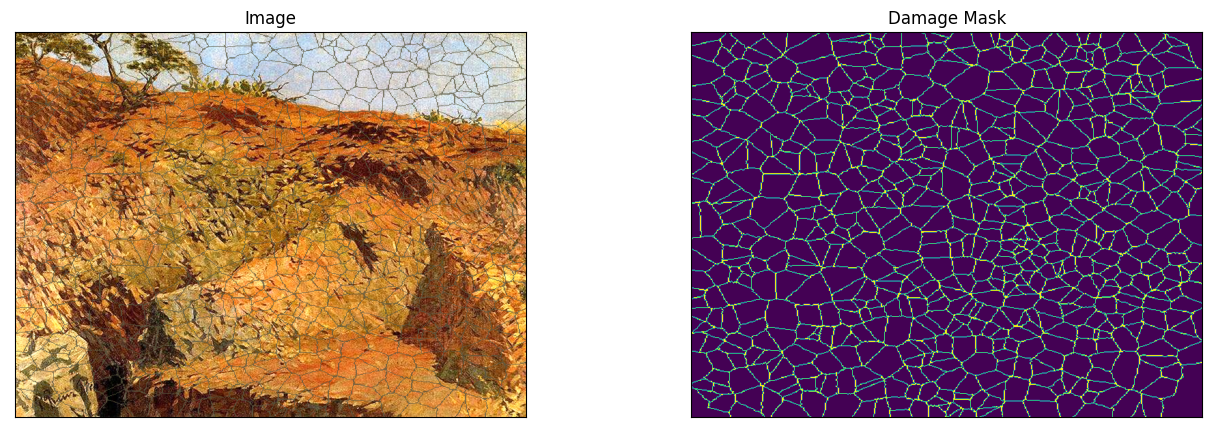

In [7]:
# Let"s look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=["damage"])

image, mask = dataset[5]  # get some sample
visualize(
    image=denormalize(image),
    damage_mask=mask[..., 0].squeeze()
)


## Augmentations

In [8]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# Define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(
            scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0
        ),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.Perspective(scale=(0.05, 0.1), keep_size=True, p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(brightness_limit=0.2, p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),

        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


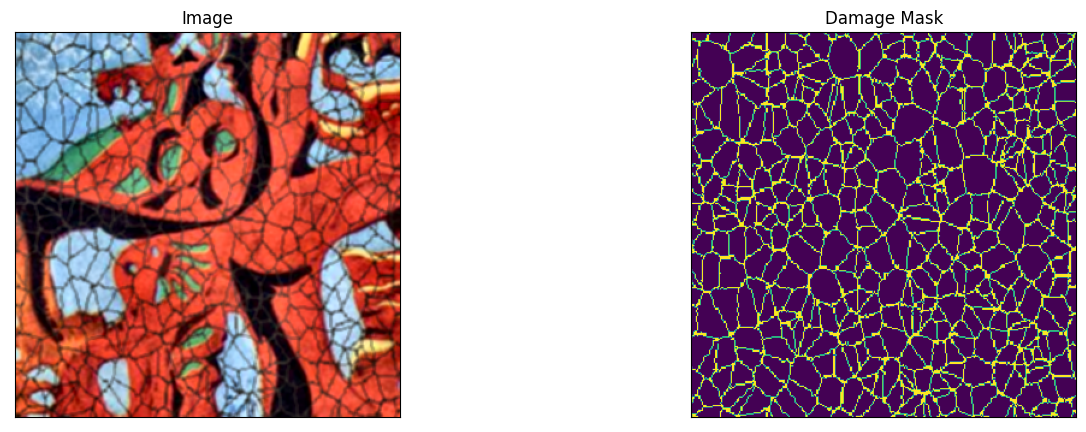

In [9]:
# Let"s look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=["damage"], augmentation=get_training_augmentation())

image, mask = dataset[12]  # get some sample
visualize(
    image=denormalize(image),
    damage_mask=mask[..., 0].squeeze(),
)


## Segmentation and model training

In [10]:
# Model and training configuration
BACKBONE = "resnet34"
ENCODER_WEIGHTS = "imagenet"
BATCH_SIZE = 16
CLASSES = ["damage"]
LR = 0.0001
EPOCHS = 3


# Define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # add background if multiclass
activation = "sigmoid" if n_classes == 1 else "softmax"     # use sigmoid for binary, softmax for multiclass

preprocess_input = sm.get_preprocessing(BACKBONE)

def image_fn(x, **kwargs):
    return preprocess_input(x) if preprocess_input else x

def mask_fn(x, **kwargs):
    return x

def build_preprocessing(preprocessing_fn=None):
    return A.Compose([
        A.Lambda(image=image_fn, mask=mask_fn)
    ])

preprocessing = build_preprocessing(preprocess_input)

In [11]:
# Create U-Net model with chosen backbone and parameters
model = sm.Unet(
    BACKBONE,
    encoder_weights=ENCODER_WEIGHTS,
    encoder_freeze=True,
    classes=n_classes,
    activation=activation
)

85524480/85521592 [==============================] - 3s 0us/step


In [12]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(LR)

# Define loss components
dice_loss = sm.losses.DiceLoss()
if n_classes == 1:
    focal_loss = sm.losses.BinaryFocalLoss()
    total_loss = dice_loss + focal_loss  # or sm.losses.binary_focal_dice_loss
else:
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + focal_loss  # or sm.losses.categorical_focal_dice_loss

# Define metrics
metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5)
]

# Compile model
model.compile(
    optimizer=optimizer,
    loss=total_loss,
    metrics=metrics
)

In [13]:
def parse_image(img_path, mask_path):
    def _parse(img_path, mask_path):
        import cv2
        import numpy as np
        img = cv2.imread(img_path.decode(), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path.decode(), cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (320, 320)) / 255.0
        mask = cv2.resize(mask, (320, 320), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype("float32")[..., np.newaxis]

        return img.astype("float32"), mask

    img, mask = tf.numpy_function(_parse, [img_path, mask_path], [tf.float32, tf.float32])
    img.set_shape([320, 320, 3])
    mask.set_shape([320, 320, 1])
    return img, mask

def build_dataset(image_paths, mask_paths, batch_size=16, is_train=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.repeat()  # <=== Fixes "input ran out of data"
        dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [14]:
# Load image and mask paths
train_img_paths = sorted(glob.glob(os.path.join(x_train_dir, "*.png")))
train_mask_paths = sorted(glob.glob(os.path.join(y_train_dir, "*.png")))

valid_img_paths = sorted(glob.glob(os.path.join(x_valid_dir, "*.png")))
valid_mask_paths = sorted(glob.glob(os.path.join(y_valid_dir, "*.png")))

test_img_paths = sorted(glob.glob(os.path.join(x_test_dir, "*.png")))
test_mask_paths = sorted(glob.glob(os.path.join(y_test_dir, "*.png")))

# Convert to tf constants
train_img_paths = tf.constant(train_img_paths)
train_mask_paths = tf.constant(train_mask_paths)

valid_img_paths = tf.constant(valid_img_paths)
valid_mask_paths = tf.constant(valid_mask_paths)

test_img_paths = tf.constant(test_img_paths)
test_mask_paths = tf.constant(test_mask_paths)

In [15]:
train_dataset = build_dataset(train_img_paths, train_mask_paths, batch_size=16, is_train=True)
valid_dataset = build_dataset(valid_img_paths, valid_mask_paths, batch_size=16, is_train=False)
test_dataset = build_dataset(test_img_paths, test_mask_paths, batch_size=1, is_train=False)

In [16]:
for x_batch, y_batch in train_dataset.take(1):
    print("Image batch shape:", x_batch.shape)
    print("Mask batch shape :", y_batch.shape)

# Define callbacks: model checkpointing and learning rate reduction
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="../../models/best_model.h5",
        save_weights_only=True,
        save_best_only=True,
        mode="min"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]


Image batch shape: (16, 320, 320, 3)
Mask batch shape : (16, 320, 320, 1)


In [17]:
# Train model using tf.keras API
history = model.fit(
    x=train_dataset,
    steps_per_epoch=len(train_img_paths) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    validation_steps=len(valid_img_paths),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/3
1512/1512 [==============================] - 763s 505ms/step - loss: 0.6762 - iou_score: 0.2987 - f1-score: 0.4493 - val_loss: 0.5481 - val_iou_score: 0.3782 - val_f1-score: 0.5424 - lr: 1.0000e-04
Epoch 2/3
1512/1512 [==============================] - 712s 471ms/step - loss: 0.5163 - iou_score: 0.4075 - f1-score: 0.5738 - val_loss: 0.4888 - val_iou_score: 0.4265 - val_f1-score: 0.5921 - lr: 1.0000e-04
Epoch 3/3
1512/1512 [==============================] - 732s 484ms/step - loss: 0.4763 - iou_score: 0.4423 - f1-score: 0.6079 - val_loss: 0.4634 - val_iou_score: 0.4540 - val_f1-score: 0.6196 - lr: 1.0000e-04


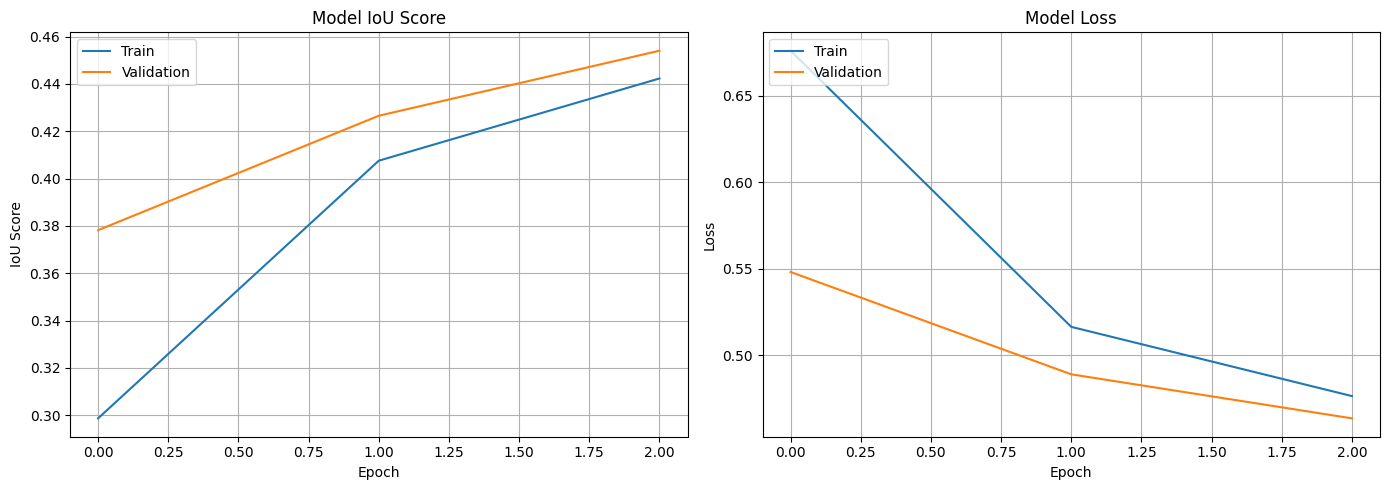

In [18]:
# Plot training history
plt.figure(figsize=(14, 5))

# Plot IOU Score
plt.subplot(1, 2, 1)
plt.plot(history.history["iou_score"], label="Train")
plt.plot(history.history["val_iou_score"], label="Validation")
plt.title("Model IoU Score")
plt.xlabel("Epoch")
plt.ylabel("IoU Score")
plt.legend(loc="upper left")
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.grid(True)

plt.tight_layout()
plt.show()


## Model evaluation

In [19]:
# Load best model weights from checkpoint
model.load_weights("../../models/best_model.h5")

In [20]:
scores = model.evaluate(test_dataset)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(model.metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.name, value))

5188/5188 [==============================] - 115s 22ms/step - loss: 0.6223 - iou_score: 0.3561 - f1-score: 0.4435
Loss: 0.62232
mean loss: 0.35609
mean iou_score: 0.44352


# Visualization of results on the test dataset

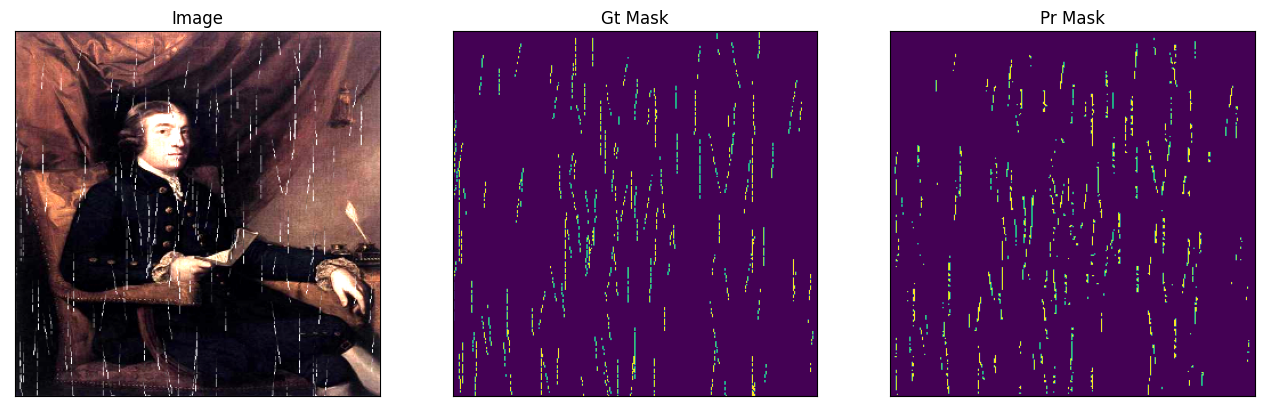

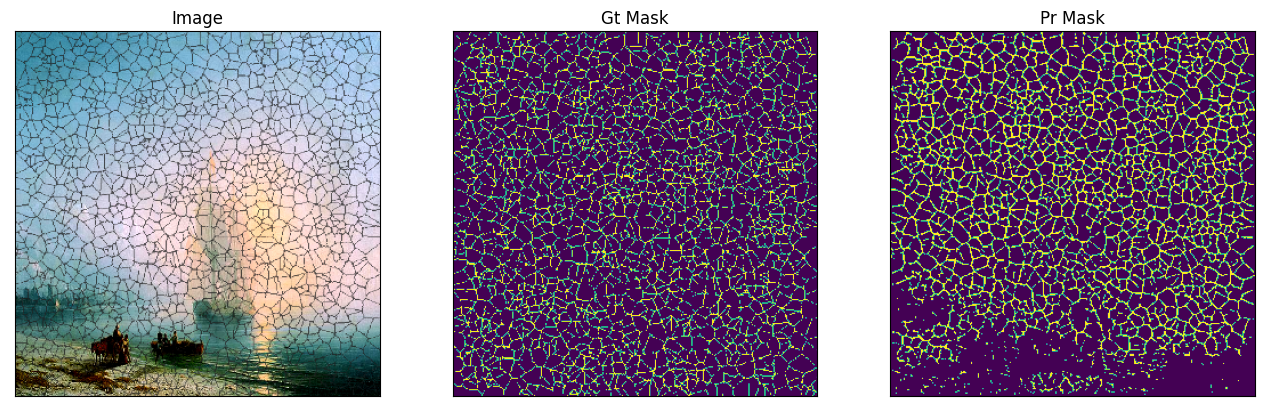

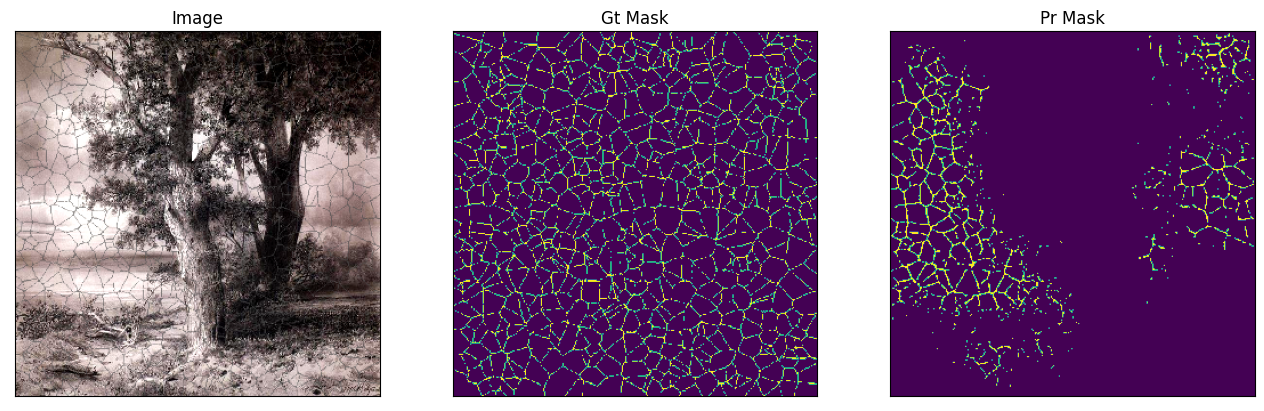

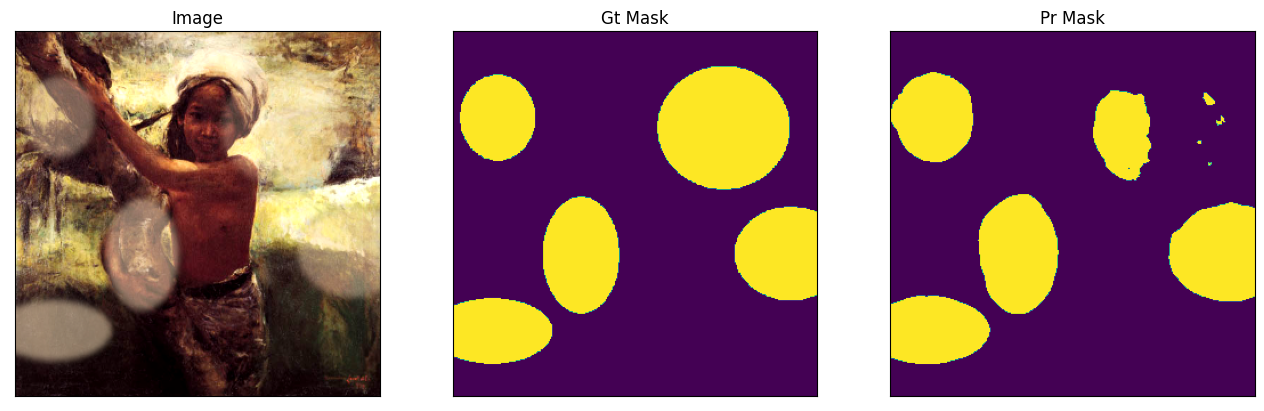

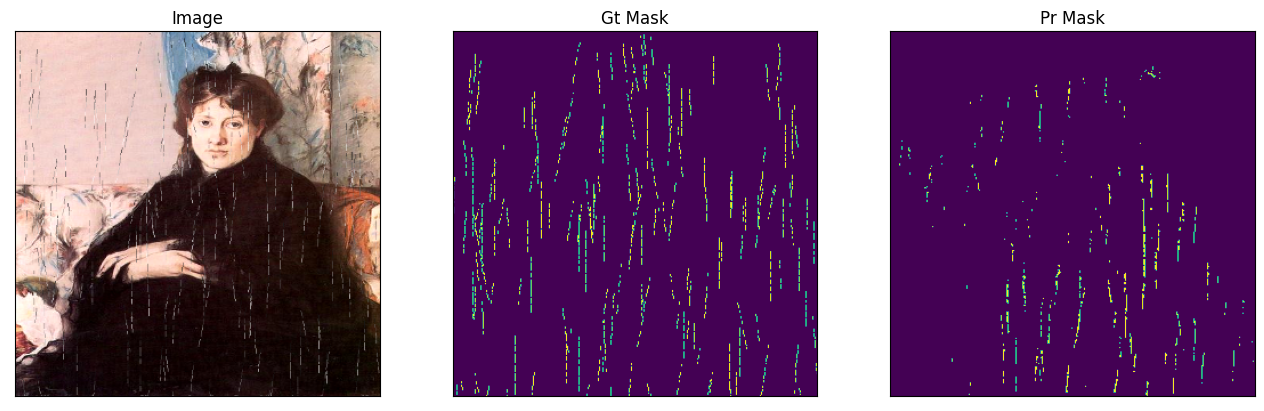

In [21]:
n = 5
sampled = random.sample(list(test_dataset.unbatch().take(100)), n)  # optional .take(100) to limit scan

for image, gt_mask in sampled:
    image_np = image.numpy()
    gt_mask_np = gt_mask.numpy()
    
    # Add batch dimension
    input_image = np.expand_dims(image_np, axis=0)
    
    # Predict and threshold
    pr_mask = model.predict(input_image)[0].round()
    
    # Visualize results
    visualize(
        image=denormalize(image_np),
        gt_mask=gt_mask_np[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )


## Testing out on real images

In [22]:
def predict_mask(model, image_path):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (320, 320))
    img = img.astype(np.float32) / 255.0

    # Add batch dimension
    input_tensor = np.expand_dims(img, axis=0)  # shape (1, 320, 320, 3)

    # Predict
    pred_mask = model.predict(input_tensor)[0]  # shape (320, 320, 1)

    # Threshold to binary
    binary_mask = (pred_mask > 0.5).astype(np.uint8)

    return img, pred_mask[..., 0], binary_mask[..., 0]


In [23]:
def visualize_prediction(model, image_path):
    original_img, prob_mask, binary_mask = predict_mask(model, image_path)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask (probability)")
    plt.imshow(prob_mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Binary Mask")
    plt.imshow(binary_mask, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

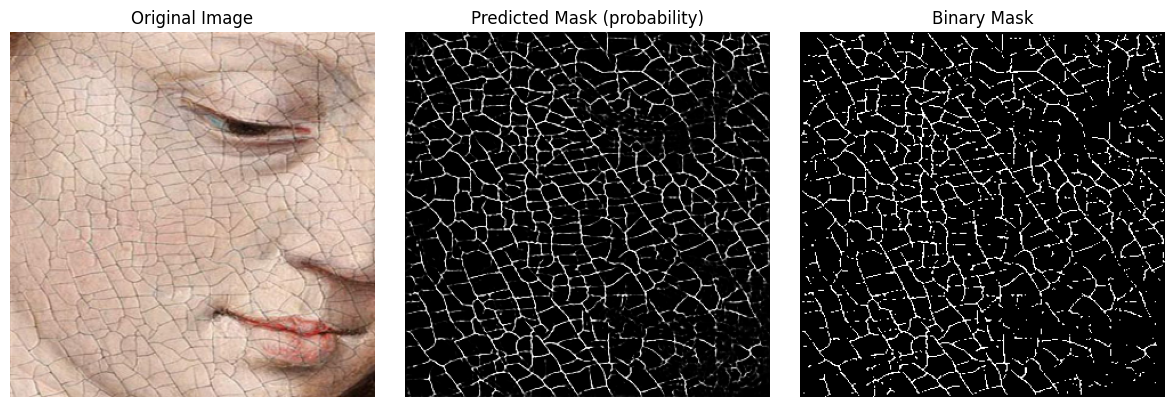

In [24]:
visualize_prediction(model, "../../data/cracked-portrait.jpg")

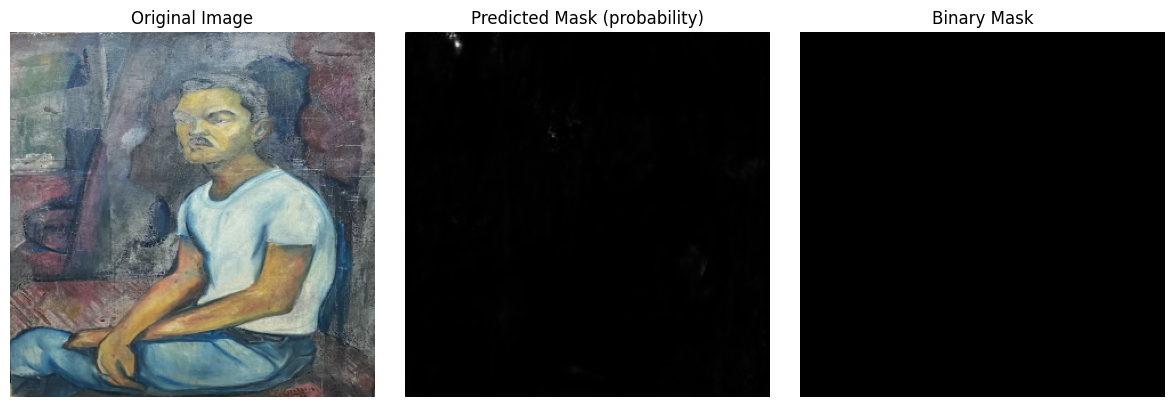

In [25]:
visualize_prediction(model, "../../data/leon-gallery-sample.jpg")

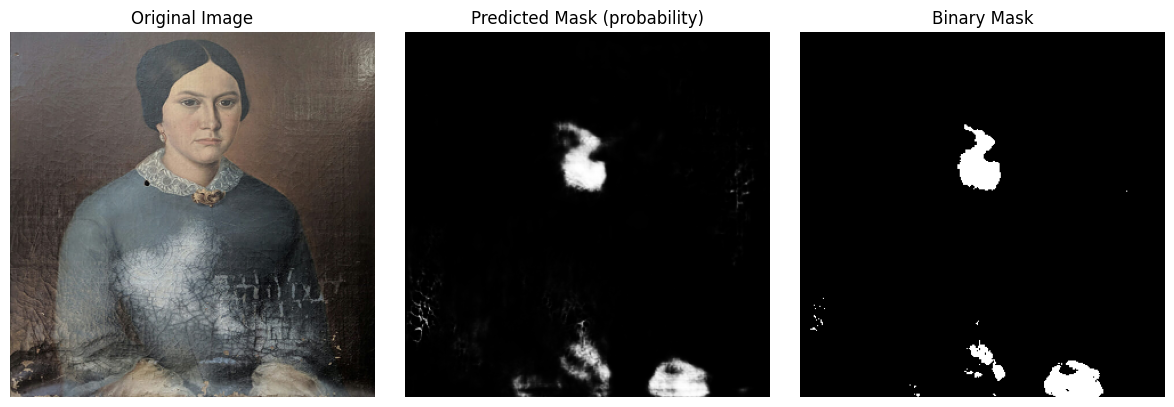

In [26]:
visualize_prediction(model, "../../data/fine-art-restoration-waterdamaged-bluelady-before.jpg")

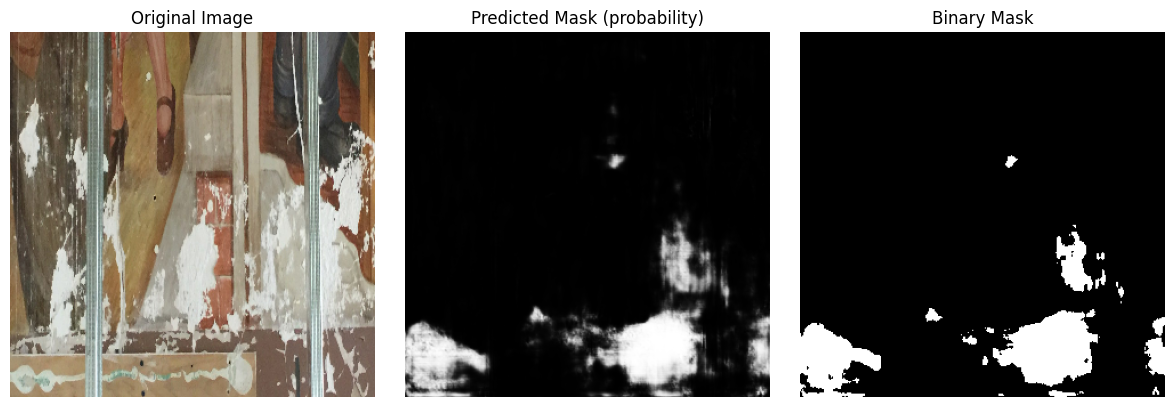

In [27]:
visualize_prediction(model, "../../data/different-types-of-art-damage-NB-min.jpg")

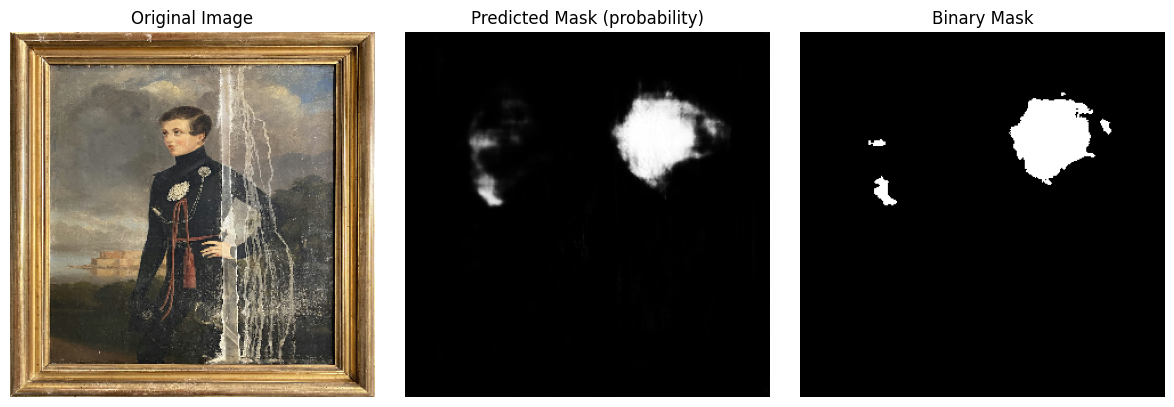

In [28]:
visualize_prediction(model, "../../data/fine-art-restoration-leak-damaged-boy-before.jpg")

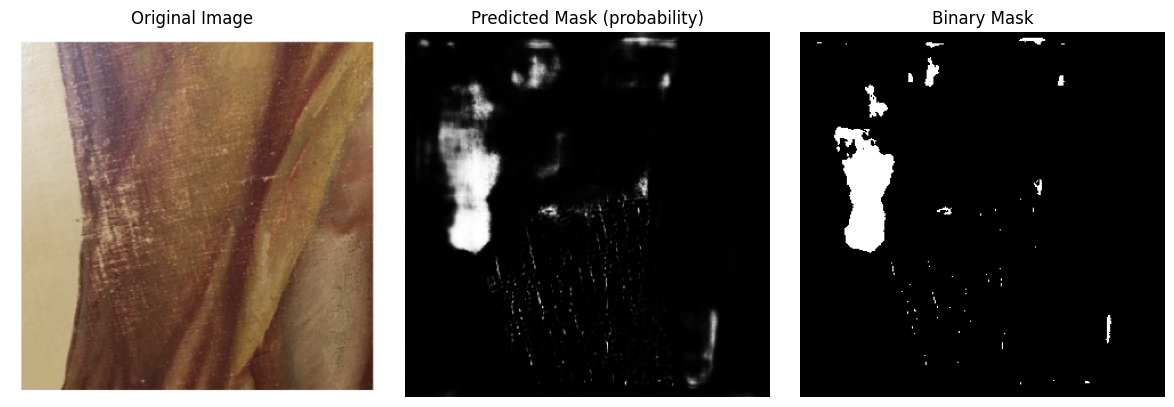

In [29]:
visualize_prediction(model, "../../data/scratch.png")